In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd

import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
query = '''select f.name, fr.film_id, sum(fr.number_of_times_rented) as n_films_rented, fr.rental_duration, fr.rental_rate, fr.length, fr.rating
from films_category_name fr
join category f
on fr.category_id = f.category_id
group by film_id;'''



data_new = pd.read_sql_query(query, engine)


## Getting information about the dataset


In [4]:
data_new.name.unique()

array(['Action', 'Animation', 'Children', 'Classics', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Foreign', 'Games', 'Horror',
       'Music', 'New', 'Sci-Fi', 'Sports', 'Travel'], dtype=object)

In [5]:
data_new.isna().sum()

name               0
film_id            0
n_films_rented     0
rental_duration    0
rental_rate        0
length             0
rating             0
dtype: int64

In [6]:
data_new.name.value_counts()

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Drama          61
Action         61
New            60
Sci-Fi         59
Games          58
Children       58
Comedy         56
Classics       54
Travel         53
Horror         53
Music          51
Name: name, dtype: int64

In [7]:
def fict_or_non(x):
    x = x.lower()
    non_ficts = ['sports', 'travel', 'documentary']
    if x in non_ficts:
        return "non fiction"
    else:
        return "fiction"

In [8]:
data_new['fiction or non-fiction'] = list(map(fict_or_non, data_new['name']))
data_new

,name,film_id,n_films_rented,rental_duration,rental_rate,length,rating,fiction or non-fiction
0,Action,19,20.0,6,0.99,113,PG,fiction
1,Action,21,21.0,3,4.99,129,R,fiction
2,Action,29,10.0,5,2.99,168,NC-17,fiction
3,Action,56,18.0,6,2.99,129,G,fiction
4,Action,67,20.0,5,2.99,77,PG-13,fiction
...,...,...,...,...,...,...,...,...
953,Travel,931,12.0,7,0.99,48,PG-13,non fiction
954,Travel,977,11.0,3,2.99,85,R,non fiction
955,Travel,981,21.0,7,0.99,55,NC-17,non fiction
956,Travel,988,15.0,7,2.99,139,R,non fiction


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
data_new = data_new.drop(["film_id", 'name'], axis=1)
data_new

,n_films_rented,rental_duration,rental_rate,length,rating,fiction or non-fiction
0,20.0,6,0.99,113,PG,fiction
1,21.0,3,4.99,129,R,fiction
2,10.0,5,2.99,168,NC-17,fiction
3,18.0,6,2.99,129,G,fiction
4,20.0,5,2.99,77,PG-13,fiction
...,...,...,...,...,...,...
953,12.0,7,0.99,48,PG-13,non fiction
954,11.0,3,2.99,85,R,non fiction
955,21.0,7,0.99,55,NC-17,non fiction
956,15.0,7,2.99,139,R,non fiction


## Getting the possible values for the dependent variable

In [11]:
data_new['fiction or non-fiction'].value_counts()

fiction        769
non fiction    189
Name: fiction or non-fiction, dtype: int64

In [12]:
import seaborn as sns

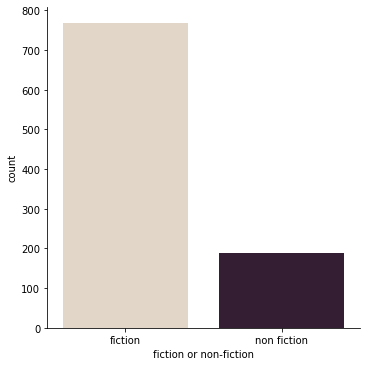

In [13]:
sns.catplot(x="fiction or non-fiction", kind="count", palette="ch:.25", data=data_new)


## Loading libraries

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

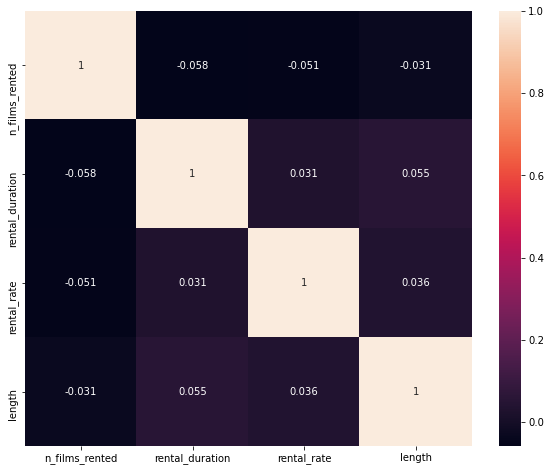

In [15]:
corr_matrix=data_new.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

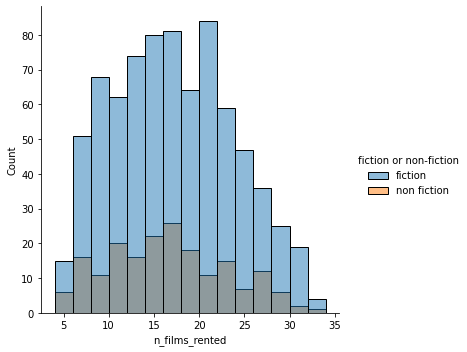

In [16]:
sns.displot(data_new, x='n_films_rented', hue='fiction or non-fiction')
plt.show()


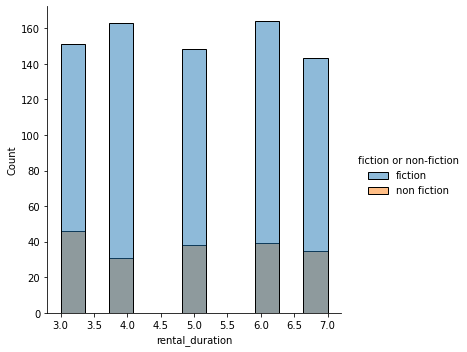

In [17]:
sns.displot(data_new, x='rental_duration', hue='fiction or non-fiction')
plt.show()

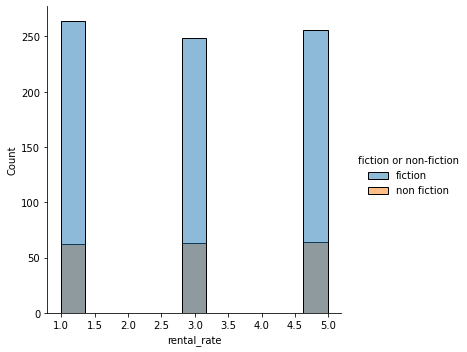

In [18]:
sns.displot(data_new, x='rental_rate', hue='fiction or non-fiction')
plt.show()

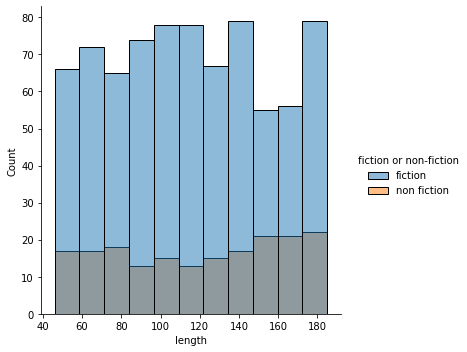

In [19]:
sns.displot(data_new, x='length', hue='fiction or non-fiction')
plt.show()

### Apply Normalizer

In [20]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
x = data_new.select_dtypes(include = np.number)

column_names=list(x.columns)

# Normalizing data
transformer = Normalizer().fit(x)
x_normalized = transformer.transform(x)
data_numerical_transformed = pd.DataFrame(x_normalized)

data_numerical_transformed.columns=column_names

In [21]:
data_numerical_transformed.head()

,n_films_rented,rental_duration,rental_rate,length
0,0.174038,0.052211,0.008615,0.983316
1,0.160516,0.022931,0.038142,0.986029
2,0.059383,0.029692,0.017756,0.997636
3,0.138013,0.046004,0.022926,0.989096
4,0.250727,0.062682,0.037484,0.965299


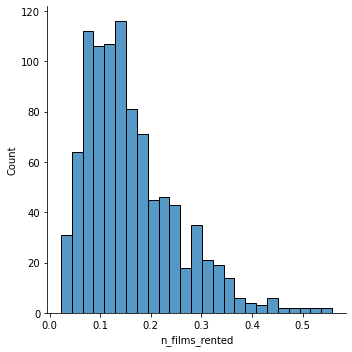

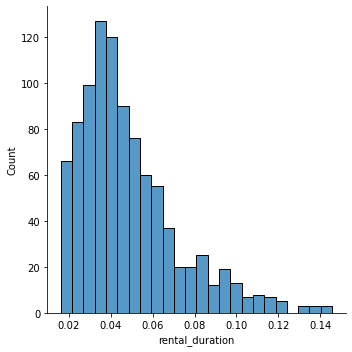

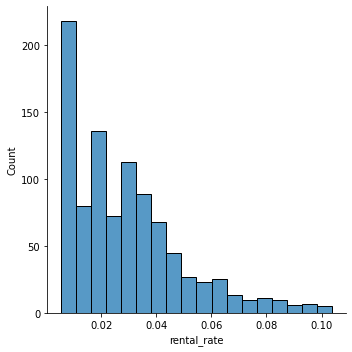

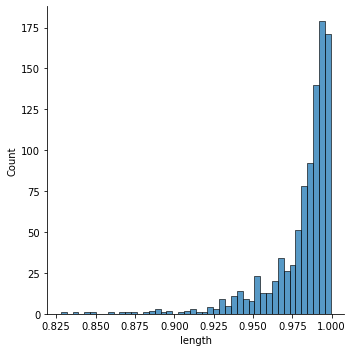

In [22]:
for col in column_names:
    sns.displot(data_numerical_transformed[col])

In [24]:
## Dummifying categorical features

cat = data_new.select_dtypes(include = np.object)

cat = cat.drop(['fiction or non-fiction'], axis=1)
categorical = pd.get_dummies(cat, columns=['rating'])

## Train-test split

In [25]:
y = data_new['fiction or non-fiction']
X = np.concatenate((data_numerical_transformed, categorical), axis=1)

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [27]:
## Train-test split

y = data_new['fiction or non-fiction']
X = np.concatenate((x, categorical), axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [28]:
import sklearn
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial', max_iter=5000).fit(X_train, y_train) #multiclass = multinomial, because our cat. feature can have more than 2 values.

## Validating the model

In [29]:
print("The accuracy of the model in the TEST set is: ", round(classification.score(X_test, y_test),2))

The accuracy of the model in the TEST set is:  0.85


In [30]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.8515625

In [31]:
y_test.value_counts()

fiction        327
non fiction     57
Name: fiction or non-fiction, dtype: int64

## Getting the confussion matrix

In [32]:
sklearn. __version__ 

'0.23.2'

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[327,   0],
       [ 57,   0]], dtype=int64)

In [34]:
## Getting the confussion matrix

sklearn. __version__ 

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[327,   0],
       [ 57,   0]], dtype=int64)

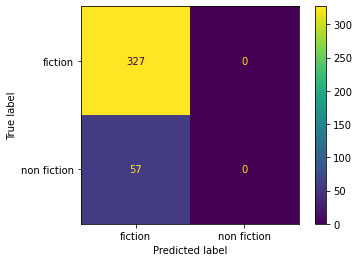

In [35]:
plot_confusion_matrix(classification, X_test, y_test)

# This is for the downsampling trial

In [36]:
#Transform into binary classification

data_new['fiction or non-fiction'] = [1 if b=='fiction' else 0 for b in data_new['fiction or non-fiction']]
 
data_new['fiction or non-fiction'].value_counts()

1    769
0    189
Name: fiction or non-fiction, dtype: int64

In [37]:
data_new2.head()

NameError: name 'data_new2' is not defined

In [38]:
from sklearn.utils import resample

In [45]:
data_new_minority = data_new[data_new['fiction or non-fiction']==0]
data_new_majority = data_new[data_new['fiction or non-fiction']==1]
 
# Downsample majority class
df_majority_downsampled = resample(data_new_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=189,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, data_new_minority])
 
# Display new class counts
df_downsampled['fiction or non-fiction'].value_counts()

1    189
0    189
Name: fiction or non-fiction, dtype: int64

In [48]:
df_downsampled.shape

(378, 6)

In [49]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
x = df_downsampled[["n_films_rented", "rental_duration", "rental_rate", "length"]]

column_names=list(x.columns)

# Normalizing data
transformer = Normalizer().fit(x)
x_normalized = transformer.transform(x)
data_numerical_transformed = pd.DataFrame(x_normalized)

data_numerical_transformed.columns=column_names

data_numerical_transformed.head()

,n_films_rented,rental_duration,rental_rate,length
0,0.161041,0.026840,0.020063,0.986379
1,0.109574,0.027393,0.034173,0.993013
2,0.182789,0.034273,0.011310,0.982490
3,0.169219,0.030218,0.005983,0.985097
4,0.141224,0.042981,0.030640,0.988569


In [50]:
## Dummifying categorical features

cat = df_downsampled.select_dtypes(include = np.object)

categorical = pd.get_dummies(cat, columns=['rating'])
categorical

,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
617,0,0,0,1,0
392,0,0,0,1,0
36,1,0,0,0,0
200,0,0,0,0,1
548,0,0,0,0,1
...,...,...,...,...,...
953,0,0,0,1,0
954,0,0,0,0,1
955,0,1,0,0,0
956,0,0,0,0,1


In [51]:
## Train-test split

y = df_downsampled['fiction or non-fiction']
X = np.concatenate((x, categorical), axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

import sklearn
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(max_iter=5000).fit(X_train, y_train) #multiclass = multinomial, because our cat. feature can have more than 2 values.

In [52]:
print("The accuracy of the model in the TEST set is: ", round(classification.score(X_test, y_test),2))

The accuracy of the model in the TEST set is:  0.53


In [53]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.5263157894736842

In [54]:
y_test.value_counts()

1    80
0    72
Name: fiction or non-fiction, dtype: int64

In [55]:
sklearn. __version__ 

'0.23.2'

In [56]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[44, 28],
       [44, 36]], dtype=int64)

In [57]:
## Getting the confussion matrix

sklearn. __version__ 

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, classification.predict(X_test))

array([[44, 28],
       [44, 36]], dtype=int64)

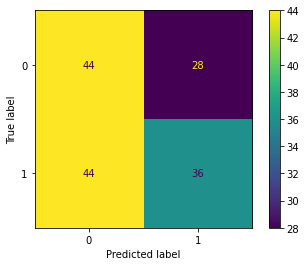

In [58]:
plot_confusion_matrix(classification, X_test, y_test)